# Full processing example

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
plt.rc('figure', figsize=(13, 7))
from matplotlib.ticker import MaxNLocator
from IPython.display import display, Markdown, Latex  # Display cells with dynamic content
from string import Template  # Replace text with $ instead of {}, much better for LaTeX equations
from os import path, makedirs  # Filesystem handling
import warnings  # Required to suppress a matplotlib warning

def round_numbers(data: dict, places: int) -> dict:
  """Setup floating point variables for string substitution

  Parameters
  ----------
  data : dict
      A dictionary of values with string keys
  places : int
      Number of decimal places in string representation

  Returns
  -------
  dict
      A copy of `data` with floats converted to strings
  """
  format_string = '{:.' + str(places) + 'f}'
  result = dict()
  for k, v in data.items():
    if isinstance(v, float):
      result[k] = format_string.format(v)
    else:
      result[k] = v
  return result

tex = lambda text, data, places = 3: display(Latex(Template(text).substitute(round_numbers(data, places))))
md = lambda text, data, places = 3: display(Markdown(Template(text).substitute(round_numbers(data, places))))

def sign(x):
  return 1 if x > 0 else -1 if x < 0 else 0

if not path.isdir('output'):
  makedirs('output')

save = lambda name: plt.savefig(f'output/{name}.png', dpi=300, transparent=True)

## Data definition

In [55]:
numlevels = 32

In [56]:
# # KoSMOS data
# datastring = 'ZIQLRLVQVJPKRLRMUPUNTOTOTMSNSNSNULQLUMTHRMTOUPVOULSNSNTOTNUNT' \
#   'OTNSNSNSNUOULUOUIXSXNTOUOUPUPUNSKSNTLQLSNTOUHSNSNSNSNSNSNSIQPUHUPUOTOTOU' \
#   'MTMSNTOTOTOTOTNSNSNSNSLSNSHTOTOTNSLSMSLSNSMSNTNSNTLSNSNTMUPUOTOTOUOTOTOT' \
#   'OTNUPVPUNTOTJRMSNTNSNSNSNSNSMRLQJUPVNSNTOTMSLTNTOWNSNSNSNTNTOTMRLVKRLSLS' \
#   'NSNTOTOTOUOTOTNTNSMTNUNTOTOTOUIWRWMTOTKSNSNUNSNUPUPUOTNTHTOTOUOUNSNUMUKS' \
#   'HYTXSXOTOTOTOUOTOTOTLSNSNULSNSNTOTOULSNTNSNUPVOTOTOVFSNSNUHXSXSXQVMVNSLR' \
#   'LQKVPUPUNUNUNUPUOTNTOTOTMSMTLSNSNSNSNTOTOVOTNUNSNSLQLSNSNSNTNSKWRWRWRWRW' \
#   'JSMRMSNTOUNUOUJSNTOTOTNSMRLQGRMRLSNTOTOTOTMRKULSNSNTMSNTNVOTOTMTOTOTMRMU' \
#   'OTOVLRMTOUPUPULTOTOTMRFTOTMYKPIUNSMRMRMSNTMTHRMSNUGVQWPUOUPVOTNSNSNSNSNT' \
#   'OVHQLSLSMRMSNZORMUPUOTOVNSMSNSNSMTOTOTOTNTOTLSNSNSNSNSNSNVOTOUKSLQKPKSKR' \
#   'MRJUNTNSNTOUPUJPKVMSNTNSNUPUPUPVPUKVLSNVJPKSNTKSNSNSIONSNSNUNTORKVPUOTOV' \
#   'MSNSMTOTOTNTOVQVPUJOJSNTNTOTNSNSNULWRWQWRXSXSXSXSXSXRWRWRXOTOTOTOVNSNSNT' \
#   'NTOTNSNSNSNUOTOTOTNSNSKVOTOTHUPXSXSXQVLSNTNTMTOTMTOUPUPVP'
# data = [ord(c) - ord('A') + 4 for c in datastring]

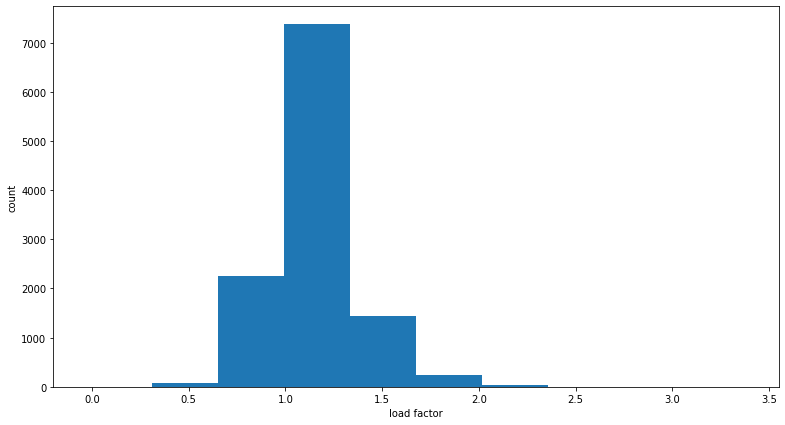

smallest [-0.03  0.1   0.21  0.23  0.24  0.3   0.33  0.36  0.4   0.41]
largest [2.19 2.19 2.2  2.23 2.3  2.37 2.58 2.63 3.38 5.03]


In [57]:
log_full = np.loadtxt('data/log_20141114T153149.csv', delimiter=';', skiprows=1)
load_factors = log_full[:, 1]

plt.hist(np.where(load_factors < 5, load_factors, 1))
plt.ylabel('count')
plt.xlabel('load factor')
save('data_histogram')
plt.show()

sorted_loads = np.sort(load_factors)
print('smallest', sorted_loads[:10])
print('largest', sorted_loads[-10:])

In [58]:
class Extents:
  low_level = 1
  low_factor = 0.0
  high_level = 32
  high_factor = 3.0

  min_level = 1
  max_level = 32

  @staticmethod
  def loadlevel(lf):
    alpha = (lf - Extents.low_factor) / (Extents.high_factor - Extents.low_factor)
    raw_level = np.floor(Extents.low_level + alpha * (Extents.high_level - Extents.low_level))
    return np.clip(raw_level, Extents.min_level, Extents.max_level)

load_levels = Extents.loadlevel(load_factors)

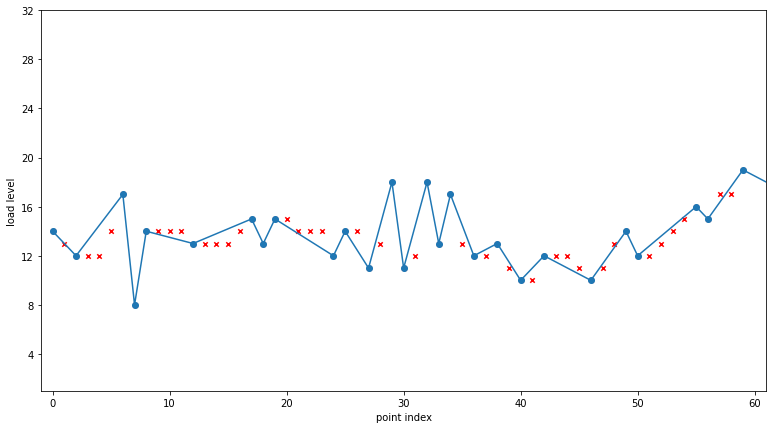

data length before: 11419
             after: 4995 


In [59]:
def only_extremes(l) -> list:
  extremes = [l[0], l[1]]
  indices = [0, 1]
  for i, n in enumerate(l):
    if i <= 1:
      continue  # Skip initial two
    if n == extremes[-1]:
      continue  # Skip if value unchanged
    if sign(extremes[-1] - extremes[-2]) != sign(n - extremes[-1]):
      # Direction changed, add this point
      extremes.append(n)
      indices.append(i)
    else:
      # Still going the same way, replace last point with this
      extremes[-1] = n
      indices[-1] = i

  return indices, extremes

i, e = only_extremes(load_levels)
plotted_count = 60

fig, ax = plt.subplots()
ax.scatter(np.arange(plotted_count), load_levels[:plotted_count], marker='x', s=20, c='red')
ax.plot(i[:plotted_count], e[:plotted_count])
ax.scatter(i[:plotted_count], e[:plotted_count])
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylim([1, 32])
plt.xlim([-1, plotted_count+1])
plt.ylabel('load level')
plt.xlabel('point index')
save('filtering')
plt.show()

print(f'data length before: {len(load_levels)}\n' \
      f'             after: {len(e)} ')

data = np.array(e)

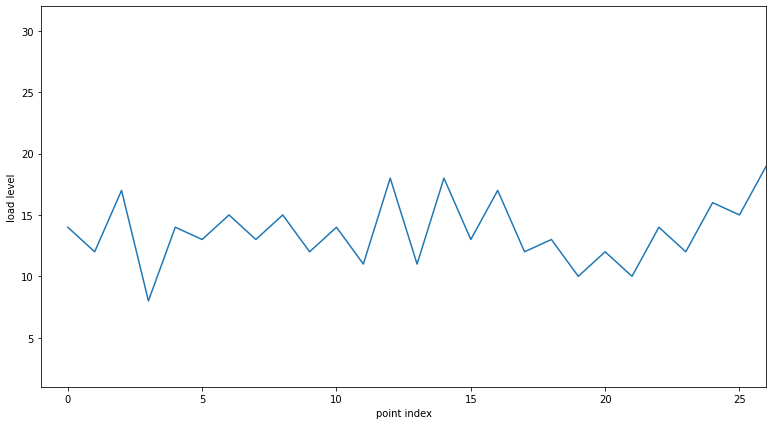

In [60]:
plt.plot(data)
plt.ylim([1, 32])
plt.xlim([-1, 26])
plt.ylabel('load level')
plt.xlabel('point index')
save('filtered')
plt.show()

## Transfer array

In [61]:
transfers = []
for i, d in enumerate(data[:-1]):
  transfers.append((int(d), int(data[i+1])))

transfer_counts = np.zeros((numlevels, numlevels), dtype=np.intc)
for frm, to in transfers:
  transfer_counts[frm - 1, to - 1] += 1

In [62]:
table_rows = [ '| From\\To | &nbsp;&nbsp;' + ' | &nbsp;&nbsp;'.join([str(n + 1) for n in range(numlevels)]),
'| --: '*(numlevels + 1) + '|' ]
for m in reversed(range(numlevels)):
  row = '| **' + str(m+1) + '** |'
  for n in range(numlevels):
    if m == n:
      row += ' X |'
    elif transfer_counts[m, n] != 0:
      row += ' ' + str(transfer_counts[m, n]) + '|'
    else:
      row += '.|'
  table_rows.append(row)

table = '\n'.join(table_rows)
display(Markdown(table))

| From\To | &nbsp;&nbsp;1 | &nbsp;&nbsp;2 | &nbsp;&nbsp;3 | &nbsp;&nbsp;4 | &nbsp;&nbsp;5 | &nbsp;&nbsp;6 | &nbsp;&nbsp;7 | &nbsp;&nbsp;8 | &nbsp;&nbsp;9 | &nbsp;&nbsp;10 | &nbsp;&nbsp;11 | &nbsp;&nbsp;12 | &nbsp;&nbsp;13 | &nbsp;&nbsp;14 | &nbsp;&nbsp;15 | &nbsp;&nbsp;16 | &nbsp;&nbsp;17 | &nbsp;&nbsp;18 | &nbsp;&nbsp;19 | &nbsp;&nbsp;20 | &nbsp;&nbsp;21 | &nbsp;&nbsp;22 | &nbsp;&nbsp;23 | &nbsp;&nbsp;24 | &nbsp;&nbsp;25 | &nbsp;&nbsp;26 | &nbsp;&nbsp;27 | &nbsp;&nbsp;28 | &nbsp;&nbsp;29 | &nbsp;&nbsp;30 | &nbsp;&nbsp;31 | &nbsp;&nbsp;32
| --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: |
| **32** |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| 1|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |
| **31** |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|
| **30** |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|
| **29** |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|.|
| **28** |.|.|.|.|.|.|.|.|.|.| 1|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|.|.|
| **27** |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|.|.|.|
| **26** |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|.|.|.|.|
| **25** |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|.|.|.|.|.|
| **24** |.|.|.|.|.|.|.|.|.|.| 1|.|.| 1|.|.|.|.|.|.|.|.|.| X |.|.|.|.|.|.|.|.|
| **23** |.|.|.|.|.|.|.| 2|.|.| 1| 1|.|.|.|.|.|.|.| 1|.|.| X |.|.|.|.|.|.|.|.|.|
| **22** |.|.|.|.|.|.|.|.|.| 1|.| 1|.|.|.|.| 1| 2|.| 1|.| X |.|.|.|.|.|.|.|.|.|.|
| **21** |.|.|.|.|.|.|.|.|.|.|.| 2| 2| 2| 2| 2| 2| 4| 2| 1| X |.|.|.|.|.|.|.|.|.|.|.|
| **20** |.|.|.|.| 1|.|.|.|.|.| 2| 3| 1| 7| 2| 3| 4| 1| 1| X | 2| 1|.|.|.|.|.|.|.|.|.|.|
| **19** |.|.|.|.| 1|.|.|.|.| 2| 1| 10| 3| 4| 5| 8| 6| 1| X | 2|.| 1|.|.|.|.|.|.|.|.|.|.|
| **18** |.|.|.|.|.| 1|.| 3| 4|.| 3| 7| 7| 13| 6| 9| 8| X | 4| 2| 1| 1|.|.|.|.|.|.|.|.|.|.|
| **17** |.| 1| 1|.|.|.|.| 3| 6| 6| 12| 12| 12| 20| 17| 20| X | 8| 8| 2| 2|.|.| 1|.|.|.|.|.|.|.|.|
| **16** |.|.|.|.| 1| 3|.| 7| 6| 8| 20| 30| 23| 19| 23| X | 18| 11| 6| 2| 4| 1| 1|.|.|.|.|.|.|.|.|.|
| **15** | 1|.|.| 1|.| 1| 4| 8| 14| 25| 46| 43| 31| 33| X | 18| 12| 10| 7| 5| 1| 1|.| 1|.|.|.|.|.|.|.|.|
| **14** |.|.| 1|.|.| 2| 4| 9| 29| 51| 102| 98| 56| X | 31| 23| 23| 7| 4| 6| 4|.| 1|.|.|.|.|.|.|.|.|.|
| **13** |.|.|.|.| 1| 3| 8| 20| 59| 139| 229| 163| X | 50| 30| 20| 20| 8| 2| 2| 2| 1|.|.|.|.|.|.|.|.|.|.|
| **12** |.|.|.| 1|.| 4| 8| 30| 73| 188| 379| X | 176| 97| 48| 25| 11| 3| 5| 2| 1|.| 2|.|.|.|.|.|.|.|.|.|
| **11** |.|.|.| 1| 1| 2| 8| 22| 45| 89| X | 363| 249| 89| 46| 24| 11| 9| 3| 1|.|.| 1|.|.|.|.| 1|.|.|.|.|
| **10** |.|.|.|.| 3| 2| 3| 10| 28| X | 78| 202| 117| 71| 21| 7| 6| 3| 1| 1| 2|.|.|.|.|.|.|.|.|.|.|.|
| **9** |.|.|.|.|.|.|.| 6| X | 25| 52| 77| 53| 26| 15| 10| 3| 1| 1|.|.|.|.|.|.|.|.|.|.|.|.| 1|
| **8** |.|.|.|.|.| 1|.| X | 5| 15| 27| 28| 16| 10| 7| 9| 2| 1|.|.|.|.|.|.|.|.|.|.|.|.|.|.|
| **7** |.|.|.|.|.| 1| X | 1|.| 3| 5| 8| 7| 6| 2| 1| 2|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|
| **6** |.|.|.|.|.| X |.|.|.| 2| 5| 4| 2| 1| 3| 3|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|
| **5** |.|.|.|.| X |.|.|.| 1|.| 1| 1|.|.| 4|.| 1|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|
| **4** |.|.|.| X |.|.|.|.|.| 1| 1|.|.|.|.|.| 1|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|
| **3** |.|.| X |.|.|.| 1|.|.|.|.|.|.| 1|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|
| **2** |.| X |.|.|.|.|.|.|.|.|.|.| 1|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|
| **1** | X |.|.|.|.|.|.|.|.|.|.|.| 1|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|

In [63]:
np.savetxt('output/advanced_transfer_counts.csv', transfer_counts[::-1], fmt='%d', delimiter=';')

## Rain flow counting

In [64]:
def make_droplets(data: list, direction: int, separation=0.2) -> list:
  assert direction != 0
  direction = sign(direction)
  droplets = []
  taken_peaks = []
  for i, start in enumerate(data[:-1]):
    if sign(data[i + 1] - start) == direction:
      drop = { 'from': int(start), 'points': [(i, start)]}
      current_d = start
      for j in range(i+1, len(data)):
        if (data[j] - current_d) * direction >= 0:  # Fall on the next line
          taken_index = next((i for i, x in enumerate(taken_peaks) if x['index'] == j), -1)
          old_intercept = taken_peaks[taken_index]['intercept'] if taken_index != -1 else np.NaN

          if len(drop['points']) > 1:
            # Move the last point to intercept this roof nicely
            intercept_delta_x = (current_d - data[j-1]) / (data[j] - data[j-1])
            drop['points'][-1] = (drop['points'][-1][0] + intercept_delta_x, drop['points'][-1][1])
            # Store all interceptions to allow checking for collisons
            if taken_index == -1:
               taken_peaks.append({'index': j, 'intercept': current_d})
            else:
              taken_peaks[taken_index] = { 'index': j, 'intercept': current_d}

          if taken_index != -1:
            lerp_arg = ((old_intercept - direction * separation) - data[j-1]) / (data[j] - data[j-1])
            
            drop['points'].append((j-1+ lerp_arg, data[j-1] + lerp_arg * (data[j] - data[j-1])))
            drop['to'] = int(old_intercept)
            break

          drop['points'].append((j, data[j]))
          current_d = data[j]

        else:
          drop['points'].append((j, current_d))  # Fall down straight

          if (data[j] - drop['from']) * direction < 0:  # Termination condition
            drop['to'] = int(current_d)
            break

        if j == len(data) - 1:  # Extend beyond last point
          drop['points'].append((j + 1, current_d))
          drop['to'] = int(current_d)

      droplets.append(drop)
  return droplets

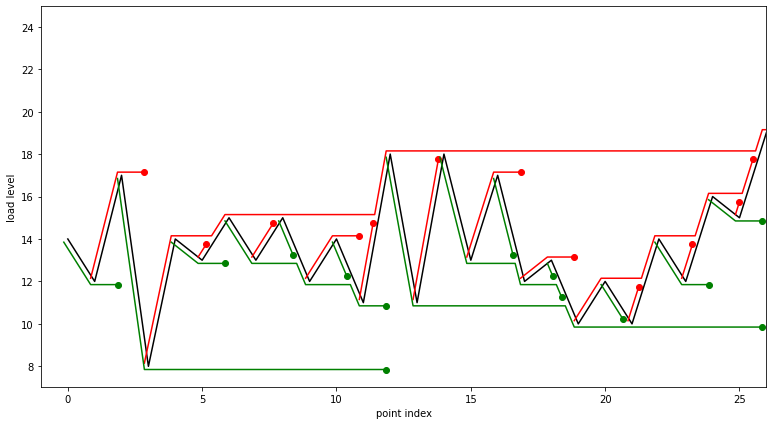

In [65]:
plotted_count = 25
plt.plot(data[:plotted_count + 2], c='black')

drops_top = make_droplets(data, 1, separation=0.4)
for drop in drops_top:
  if drop['points'][0][0] > plotted_count:
    break
  points = np.array(drop['points'])
  # Offset diagonally by a small value to display next to original data
  points = points + np.tile(np.array([-0.15, 0.15]), (points.shape[0], 1))
  plt.plot(points[:,0], points[:,1], c='red')
  plt.scatter(points[-1, 0], points[-1, 1], c='red')

drops_bottom = make_droplets(data, -1, separation=0.4)
for drop in drops_bottom:
  if drop['points'][0][0] > plotted_count:
    break
  points = np.array(drop['points'])
  points = points + np.tile(np.array([-0.15, -0.15]), (points.shape[0], 1))
  plt.plot(points[:,0], points[:,1], c='green')
  plt.scatter(points[-1, 0], points[-1, 1], c='green')

plt.xlim([-1, plotted_count + 1])
plt.ylabel('load level')
plt.xlabel('point index')
save('rain_flow')
plt.show()

In [66]:
drops_all = drops_top + drops_bottom
halfcycle_counts = np.zeros((numlevels, numlevels), dtype=np.intc)
for d in drops_all:
  halfcycle_counts[d['from'] - 1, d['to'] - 1] += 1

In [67]:
table_rows = [ '| From\\To | &nbsp;&nbsp;' + ' | &nbsp;&nbsp;'.join([str(n + 1) for n in range(numlevels)]),
'| --: '*(numlevels + 1) + '|' ]
for m in reversed(range(numlevels)):
  row = '| **' + str(m+1) + '** |'
  for n in range(numlevels):
    if m == n:
      row += ' X |'
    elif halfcycle_counts[m, n] != 0:
      if halfcycle_counts[n, m] != 0:
        row += ' ' + str(halfcycle_counts[m, n]) + '|'
      else:
        row += ' [' + str(halfcycle_counts[m, n]) + ']|'
    else:
      row += '.|'
  table_rows.append(row)

table = '\n'.join(table_rows)
display(Markdown(table))

| From\To | &nbsp;&nbsp;1 | &nbsp;&nbsp;2 | &nbsp;&nbsp;3 | &nbsp;&nbsp;4 | &nbsp;&nbsp;5 | &nbsp;&nbsp;6 | &nbsp;&nbsp;7 | &nbsp;&nbsp;8 | &nbsp;&nbsp;9 | &nbsp;&nbsp;10 | &nbsp;&nbsp;11 | &nbsp;&nbsp;12 | &nbsp;&nbsp;13 | &nbsp;&nbsp;14 | &nbsp;&nbsp;15 | &nbsp;&nbsp;16 | &nbsp;&nbsp;17 | &nbsp;&nbsp;18 | &nbsp;&nbsp;19 | &nbsp;&nbsp;20 | &nbsp;&nbsp;21 | &nbsp;&nbsp;22 | &nbsp;&nbsp;23 | &nbsp;&nbsp;24 | &nbsp;&nbsp;25 | &nbsp;&nbsp;26 | &nbsp;&nbsp;27 | &nbsp;&nbsp;28 | &nbsp;&nbsp;29 | &nbsp;&nbsp;30 | &nbsp;&nbsp;31 | &nbsp;&nbsp;32
| --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: |
| **32** | [1]|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |
| **31** |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|
| **30** |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|
| **29** |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|.|
| **28** |.|.|.|.| 1|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|.|.|
| **27** |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|.|.|.|
| **26** |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|.|.|.|.|
| **25** |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|.|.|.|.|.|
| **24** |.| [1]|.| [1]|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|.|.|.|.|.|.|
| **23** |.|.|.| 1| 1|.|.| [1]| 2|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|.|.|.|.|.|.|.|
| **22** |.|.| 1| 1| 1| 1|.|.|.|.|.| 1|.|.|.|.|.|.|.| 1|.| X |.|.|.|.|.|.|.|.|.|.|
| **21** |.|.| 1|.| 1| 3| 2| 1| 1|.| 1| 1|.| 1| 1|.| 2| 1| 1| 2| X |.|.|.|.|.|.|.|.|.|.|.|
| **20** |.|.|.|.| 1| 1| 1| 1| 3| 1|.| 3| 1| 4|.| 2| 2| 3| 2| X | 2| 1|.|.|.|.|.|.|.|.|.|.|
| **19** |.|.|.|.| 3|.| 4| 4| 1| 2| 4| 2| 2| 3| 3| 3| 6| 4| X | 2| 1|.|.|.|.|.|.|.|.|.|.|.|
| **18** |.|.|.|.|.| 2| 4| 3| 3| 5| 4| 5| 2| 6| 6| 10| 11| X | 4| 3| 1|.|.|.|.|.|.|.|.|.|.|.|
| **17** |.|.|.|.|.| 2|.| 10| 3| 5| 11| 10| 9| 16| 16| 28| X | 11| 6| 2| 2|.|.|.|.|.|.|.|.|.|.|.|
| **16** |.|.|.|.|.| 6| 5| 20| 9| 3| 10| 20| 15| 23| 29| X | 28| 10| 3| 2|.|.|.|.|.|.|.|.|.|.|.|.|
| **15** |.|.|.|.|.| 3| 9| 23| 29| 20| 28| 21| 28| 46| X | 29| 16| 6| 3|.| 1|.|.|.|.|.|.|.|.|.|.|.|
| **14** |.|.|.|.|.|.| 4| 20| 55| 73| 49| 73| 78| X | 46| 23| 16| 6| 3| 4| 1|.|.|.|.|.|.|.|.|.|.|.|
| **13** |.|.|.|.|.| 1|.| 6| 42| 141| 198| 234| X | 78| 28| 15| 9| 2| 2| 1|.|.|.|.|.|.|.|.|.|.|.|.|
| **12** |.|.|.|.|.|.| 2| 6| 42| 141| 492| X | 234| 72| 21| 20| 11| 5| 2| 3| 1| 1|.|.|.|.|.|.|.|.|.|.|
| **11** |.|.|.|.|.|.| 2| 12| 36| 118| X | 492| 198| 49| 28| 10| 11| 4| 4|.| 1|.|.|.|.|.|.|.|.|.|.|.|
| **10** |.|.|.|.|.|.| 1| 7| 38| X | 118| 141| 141| 73| 20| 3| 5| 5| 2| 1|.|.|.|.|.|.|.|.|.|.|.|.|
| **9** |.|.|.|.|.|.|.| 6| X | 38| 37| 42| 42| 55| 29| 8| 3| 3| 1| 3| 1|.| 2|.|.|.|.|.|.|.|.|.|
| **8** |.|.|.|.|.|.| 1| X | 6| 7| 12| 6| 6| 20| 23| 21| 9| 3| 4| 1| 1|.|.| [1]|.|.|.|.|.|.|.|.|
| **7** |.|.|.|.|.| 1| X | 1|.| 1| 2| 2|.| 4| 9| 5|.| 4| 4| 1| 2|.|.|.|.|.|.|.|.|.|.|.|
| **6** |.|.|.|.|.| X | 1|.|.|.|.|.| 1|.| 3| 6| 2| 2|.| 1| 3| 1|.|.|.|.|.|.|.|.|.|.|
| **5** |.|.|.|.| X |.|.|.|.|.|.|.|.|.|.|.|.|.| 3| 1| 1| 1| 1|.|.|.|.| 1|.|.|.|.|
| **4** |.|.|.| X |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| 1| 1|.|.|.|.|.|.|.|.| [1]|
| **3** |.|.| X |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| 1| 1|.|.|.|.|.|.|.|.|.|.|
| **2** |.| X |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| [1]|.|.|.|.|.|.|.|.|.|
| **1** | X |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| [1]|.|.|.|.|.|.|.|.|

In [68]:
np.savetxt('output/advanced_halfcycle_counts.csv', halfcycle_counts[::-1], fmt='%d', delimiter=';')

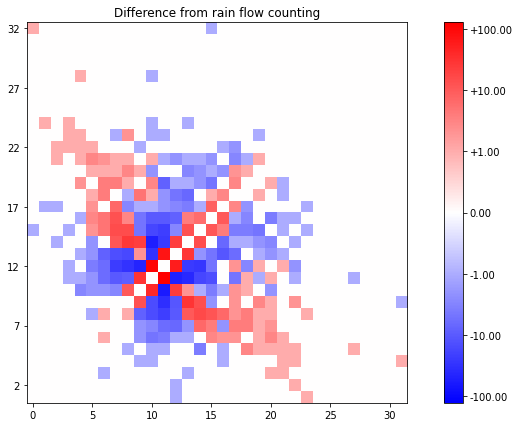

In [102]:
arrays_diff = halfcycle_counts - transfer_counts
# Join together two log scales for integers, the small number added prevents trying to take a log of 0
dual_log = lambda x: np.multiply(np.sign(x), np.log10(np.abs(x) + 0.00001) + 1)

fig, ax = plt.subplots()
im = ax.imshow(dual_log(arrays_diff[::-1]), cmap=cm.bwr, vmax=abs(dual_log(arrays_diff)).max(), vmin=-abs(dual_log(arrays_diff)).max())
cb = fig.colorbar(im)

# This code is fine, because list comprehensions are used to adapt to ticks 
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    # UserWarning: FixedFormatter should only be used together with FixedLocator
    cb.set_ticklabels(['0.00' if t == 0 else f'{"+" if t > 0 else "-"}{10 ** (np.abs(t) - 1):.2f}' for t in cb.get_ticks()])
    ax.set_yticklabels([int(32 - y) for y in ax.get_yticks()])

plt.title('Difference from rain flow counting')
save('rain_diff')
plt.show()

## Transfer and halfcycle check

$$ N - 1 = \sum{\Delta LL_{TA}} = \sum{\Delta LL_{top}} + \sum{\Delta LL_{bottom}} $$

In [70]:
num = {
  'n': len(data),
  'llta': len(transfers),
  'lltop': len(drops_top),
  'llbottom': len(drops_bottom)
}
tex(r'$$$$ $n - 1 = $llta = $lltop + $llbottom $$$$', num)

<IPython.core.display.Latex object>